In [1]:
using SpecialFunctions
using QuantumOptics

function fidelity(ρ, σ)
    tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2)
end


function plot_across_disk(f, discretization::Int64, radius::Float64)
    x = y = Array(range(-radius, radius, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > radius^2
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end


function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function sample_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    """Each Zernike array is of arbitrary length, but they are ordered by order. The first is Z00 to Zn0 where
    n is the number of 0th order zernike polynomials being considered."""
    Pevens = []
    eventuples = []
    for (n, zeven) in enumerate(zernike_coefficients_even)
        neven = n - 1
        push!(Pevens, [zeven[i] * R(neven, i-1, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = 0
        for peven in Pevens
            if length(peven) >= i
                total += peven[i]
            end
        end    
        push!(eventuples, (i - 1, total, rotationeven))
    end

    Podds = []
    oddtuples = []
    for (n, zodd) in enumerate(zernike_coefficients_odd)
        nodd = n - 1
        push!(Podds, [zodd[i] * R(nodd, i-1, ρ) for i in Array(range(1, length(zodd), step=1))])
    end
    for i in range(1, length(Podds), step=1)
        rotationodd = - (i - 1) * ω * t
        total = 0
        for podd in Podds
            if length(podd) >= i
                total += podd[i]
            end
        end    
        push!(oddtuples, (i - 1, total, rotationodd))
    end
    eventuples, oddtuples
end

function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        1 - real(fidelity(ψ1, ψ2))
    end
end

function H_odf(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, μ, ω)
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    eventerm = oddterm = 0
    if length(eventuples) > 0
        eventerm = mapreduce(x->x[2]*cos(x[1]*ϕ + x[3]), +, eventuples)
    end
    if length(oddtuples) > 0
        oddterm = mapreduce(x->x[2]*sin(x[1]*ϕ + x[3]), +, oddtuples)
    end
    U * cos(-μ*t + ψ + eventerm + oddterm) 
end

function H_odf_sum(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, μs, ω)
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    eventerm = oddterm = 0
    if length(eventuples) > 0
        eventerm = mapreduce(x->x[2]*cos(x[1]*ϕ + x[3]), +, eventuples)
    end
    if length(oddtuples) > 0
        oddterm = mapreduce(x->x[2]*sin(x[1]*ϕ + x[3]), +, oddtuples)
    end
    sum([U * cos(-μ*t + ψ + eventerm + oddterm) for μ in μs]) 
end

function least_squares_solution(mat, y)
    inv(transpose(mat) * mat)*transpose(mat) * y
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

toarray (generic function with 2 methods)

In [2]:
function annulus(a, b)
    function rtn(ρ, ϕ)
        if a < ρ < b
            1
        else
            0
        end
    end
end

annulus (generic function with 1 method)

In [3]:
max_order = 20
discretization = 50 # We could probably afford to make this smaller
zernike_samples = []
ordering = []
for n in range(0, max_order, step=1)
    for m in range(0, n, step=1)
        if (n-m)%2 == 0
            Zeven(ρ, ϕ) = R(n, m, ρ) * cos(m * ϕ)
            push!(zernike_samples, sample_across_unit_disk(Zeven, discretization)[3][:])
            push!(ordering, (n, m))
            if m !=0
                Zodd(ρ, ϕ) = R(n, m, ρ) * sin(m * ϕ)
                push!(zernike_samples, sample_across_unit_disk(Zodd, discretization)[3][:])
                push!(ordering, (n, -m))
            end
        end
    end
end
Z = reduce(hcat, zernike_samples);

In [4]:
r1 = .4
r2 = .6
xx, yy, zz = sample_across_unit_disk(annulus(r1, r2), discretization)
G = zz[:];

In [5]:
coefficients = least_squares_solution(Z, G)

231-element Array{BigFloat,1}:
  0.2187361519658336694760339614397309772755225120064601424586919458296081569811158
  3.753939806282153681569908783505699791300423876358578775600571076223752933862593e-18
  3.373503341833767431791543696406406082467187642357922416024884168034606173110323e-80
 -0.2401223353353360350639854777069250809026270017310722136768920880512842771193597
 -1.975911824730461766668866485981922060824704669684672862094723022388077674571508e-17
  2.656633881694091852535840660920044789942910268356863902619596282327252361324379e-79
  9.566320687017792261126418473915486405420145603920743844334470689386642825411558e-18
  2.253500232344956644436751189199479263088081345095092173904622624247116923637696e-77
  2.467209219925543223881581058742708373228942991910138774382596000715621630343081e-17
  4.790374745403949753143992048897096637103406452148249830755335518609140765816659e-78
 -0.05585190898513265850361285814955321171213124188031588174331250158435739319978067
 -3.0748950133581941

In [6]:
function sequential_exact_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b)
    """Apply all the zernike coefficients given, in order, for time T each."""
    orders = range(0, max(length(zernikeeven), length(zernikeodd)) - 1, step=1)
    function evaluator(ρ, ϕ)
        ψ = ψ0
        # Note that if I redefine orders here, it messes everything up. I don't understand julia scope.
        H(t, _) = H_odf_sum(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, [order * ω for order in orders], ω)*sigmaz(b), [], []
        _, ψ = @skiptimechecks timeevolution.master_dynamic(T, ψ, H)
        ψ = last(ψ)
    end
end

function annulus_spin_profile(ρ, ϕ)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    H(t, _) = annulus(r1, r2)(ρ, ϕ) * sigmaz(b), [], []
    evolution_time = π/2
    step_size = evolution_time/1
    T = [0.0:step_size:evolution_time;];
    _, ψ = timeevolution.master_dynamic(T, ψ0, H)
    last(ψ)
end

annulus_spin_profile (generic function with 1 method)

In [7]:
Γ = 1/62
ω = 2*π*180E3
θ = -π/2;

In [8]:
scaled_coefficients = .5 * coefficients
reconstruction = zeros(discretization*discretization)
for (i, zernike_sample) in enumerate(zernike_samples)
    reconstruction += scaled_coefficients[i] * zernike_sample
end

In [9]:
lookup = Dict(zip(ordering, scaled_coefficients));
zernike_even_coefficients = []
zernike_odd_coefficients = []
curr_even = []
curr_odd = []
for n in range(0, max_order, step=1)
    for m in range(0, n, step=1)
        if (n-m)%2 != 0
            push!(curr_even, 0)
            push!(curr_odd, 0)
        else
            if m == 0
                push!(curr_even, lookup[(n, m)]/2)
                push!(curr_odd, lookup[(n, -m)]/2)
            else
                push!(curr_even, lookup[(n, m)])
                push!(curr_odd, lookup[(n, -m)])
            end
        end
    end
    push!(zernike_even_coefficients, curr_even)
    push!(zernike_odd_coefficients, curr_odd)
    curr_even = []
    curr_odd = []
end

In [10]:
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
evolution_time =  50E-6
U = π/(evolution_time) * 2
step_size = evolution_time
T = [0.0:step_size:evolution_time;];
sequential_exact_evolution = sequential_exact_evolution_evaluator_factory(ψ0, T, zernike_even_coefficients, zernike_odd_coefficients, U, θ, ω, b)

(::var"#evaluator#21"{Ket{SpinBasis{1//2,Int64},Array{Complex{Float64},1}},Array{Float64,1},Array{Any,1},Array{Any,1},Float64,Float64,Float64,SpinBasis{1//2,Int64},StepRange{Int64,Int64}}) (generic function with 1 method)

In [11]:
using Plots
max_ρ = 1
min_ρ = .0
len = 20
ρs = range(min_ρ, max_ρ, step=max_ρ/len)
angle = 0
target2 = [Real.(expect(sigmax(b), annulus_spin_profile(ρ, angle))) for ρ in ρs]
y2s = [Real.(expect(sigmax(b), sequential_exact_evolution(ρ, angle))) for ρ in ρs];

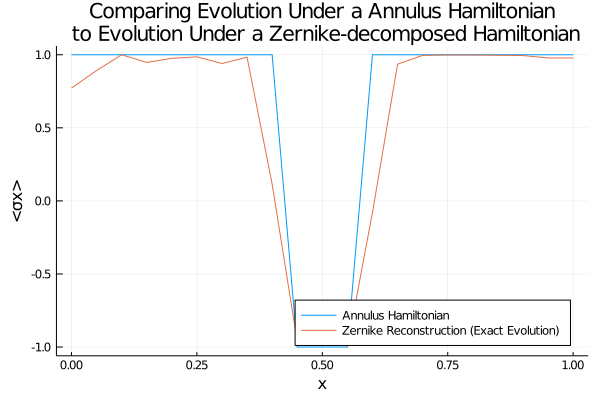

In [12]:
plot(ρs, [target2, y2s], label=["Annulus Hamiltonian" "Zernike Reconstruction (Exact Evolution)"], legend=:bottomright, ylabel="<σx>", xlabel="x", title="Comparing Evolution Under a Annulus Hamiltonian\n to Evolution Under a Zernike-decomposed Hamiltonian")

In [46]:
using Plots
function Zpoly(n::Int64, m::Int64)
    """In John's notes he includes a normalization, we have omitted that and are just following the conventions
    on Wikipedia."""
    function Z_at_point(ρ::Float64, ϕ::Float64)
        if m >= 0
            R(n, m, ρ) * cos(m * ϕ)
        else
            R(n, -m, ρ) * sin(-m * ϕ)
        end
    end
    Z_at_point
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function reconstruct_annulus(max_n, radius, discretization)
    xx, yy, total = plot_across_disk((ρ, ϕ) -> 0., discretization, radius)
    for n in range(0, max_n, step=1)
        for m in range(-n, n, step=1)
            if (n-m)%2 != 0
                coeff = 0
#             if m == 0
#                 scalar = 2
#             else
#                 scalar = 1
#             end
            else
                coeff = lookup[(n, m)]
            total += plot_across_disk(Zpoly(n, m), discretization, radius)[3] * coeff # * total_integral(n, m) * (2*n + 2) / π /scalar
            end
        end
    end
    xx, yy, total
end

reconstruct_annulus (generic function with 1 method)

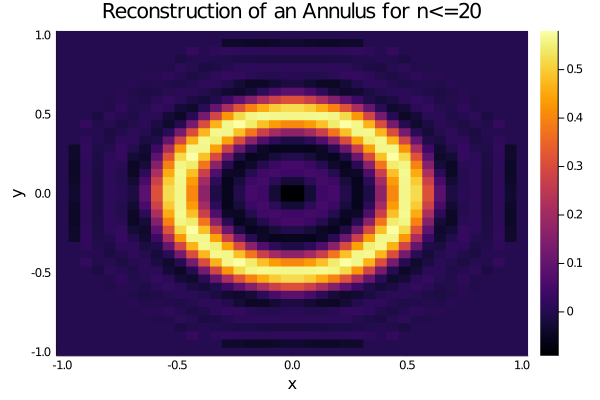

In [47]:
recon = reconstruct_annulus(20, 1., 40)
heatmap(recon, xlabel="x", ylabel="y", title="Reconstruction of an Annulus for n<=20")

In [45]:
coefficients

231-element Array{BigFloat,1}:
  0.2187361519658336694760339614397309772755225120064601424586919458296081569811158
  3.753939806282153681569908783505699791300423876358578775600571076223752933862593e-18
  3.373503341833767431791543696406406082467187642357922416024884168034606173110323e-80
 -0.2401223353353360350639854777069250809026270017310722136768920880512842771193597
 -1.975911824730461766668866485981922060824704669684672862094723022388077674571508e-17
  2.656633881694091852535840660920044789942910268356863902619596282327252361324379e-79
  9.566320687017792261126418473915486405420145603920743844334470689386642825411558e-18
  2.253500232344956644436751189199479263088081345095092173904622624247116923637696e-77
  2.467209219925543223881581058742708373228942991910138774382596000715621630343081e-17
  4.790374745403949753143992048897096637103406452148249830755335518609140765816659e-78
 -0.05585190898513265850361285814955321171213124188031588174331250158435739319978067
 -3.0748950133581941